In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

C:\Users\51man\AppData\Local\Temp\ipykernel_12636\377432509.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv('air-quality-india.csv')
data

,Timestamp,Year,Month,Day,Hour,PM2.5
0,07-11-2017 12:00,2017,11,7,12,64.51
1,07-11-2017 13:00,2017,11,7,13,69.95
2,07-11-2017 14:00,2017,11,7,14,92.79
3,07-11-2017 15:00,2017,11,7,15,109.66
4,07-11-2017 16:00,2017,11,7,16,116.50
...,...,...,...,...,...,...
36187,04-06-2022 11:00,2022,6,4,11,35.89
36188,04-06-2022 12:00,2022,6,4,12,33.83
36189,04-06-2022 13:00,2022,6,4,13,33.05
36190,04-06-2022 14:00,2022,6,4,14,35.29


In [4]:
data.shape

(36192, 6)

In [5]:
data.isna().sum()

Timestamp    0
Year         0
Month        0
Day          0
Hour         0
PM2.5        0
dtype: int64

In [6]:
data = data.drop("Timestamp",axis=1)
data

,Year,Month,Day,Hour,PM2.5
0,2017,11,7,12,64.51
1,2017,11,7,13,69.95
2,2017,11,7,14,92.79
3,2017,11,7,15,109.66
4,2017,11,7,16,116.50
...,...,...,...,...,...
36187,2022,6,4,11,35.89
36188,2022,6,4,12,33.83
36189,2022,6,4,13,33.05
36190,2022,6,4,14,35.29


In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
test_target = test_data["PM2.5"]
test_data = test_data.drop("PM2.5",axis=1)

In [9]:
len(train_data),len(test_data)

(28953, 7239)

In [10]:
features = train_data.drop("PM2.5", axis=1)  
target = train_data["PM2.5"]

Text(0.5, 1.0, 'Air Quality')

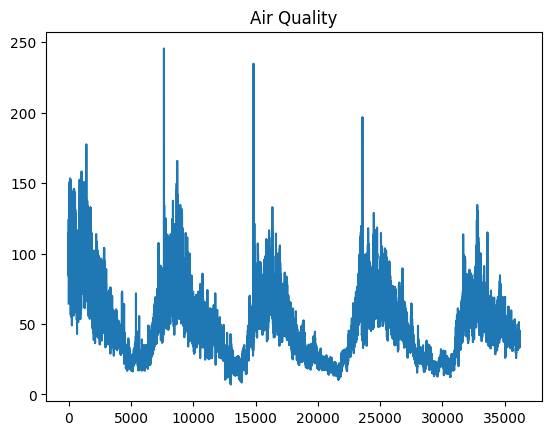

In [11]:
import matplotlib.pyplot as plt
plt.plot(data["PM2.5"])
plt.title("Air Quality")

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
test_scaled = scaler.fit_transform(test_data)

In [13]:
class PM25Dataset(TensorDataset):
    def __init__(self, features, target):
        if not isinstance(features, np.ndarray):
            features = features.to_numpy()
        if not isinstance(target, np.ndarray):
            target = target.to_numpy()
        super(PM25Dataset, self).__init__(torch.from_numpy(features).float(), torch.from_numpy(target).float())

train_dataset = PM25Dataset(features_scaled, target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = PM25Dataset(test_scaled, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [14]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.linear = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers,x.size(1), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        return self.linear(out[:, -1, :])


In [15]:
input_size = features.shape[1]
hidden_size = 32
num_layers = 1
learning_rate = 0.001
num_epochs = 10

In [16]:
model = LSTMModel(input_size=features_scaled.shape[1], hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\51man\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
train_loss = []
test_losses = []

In [18]:
for epoch in range(num_epochs):
    losses = 0
    for i, (data, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(data.unsqueeze(0))
        loss = criterion(outputs, labels)
        loss.backward()
        losses+=loss.item()
        optimizer.step()
    train_loss.append(losses/len(train_dataloader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs.unsqueeze(0))
            test_loss += criterion(outputs, labels)
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss.item())


c:\Users\51man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\51man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 598.6501


c:\Users\51man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/10], Loss: 298.4626
Epoch [3/10], Loss: 750.0638
Epoch [4/10], Loss: 1660.8774
Epoch [5/10], Loss: 463.3795
Epoch [6/10], Loss: 515.9553
Epoch [7/10], Loss: 383.6397
Epoch [8/10], Loss: 322.2277
Epoch [9/10], Loss: 281.1974
Epoch [10/10], Loss: 774.6890


Text(0.5, 1.0, 'Train Loss vs test Loss')

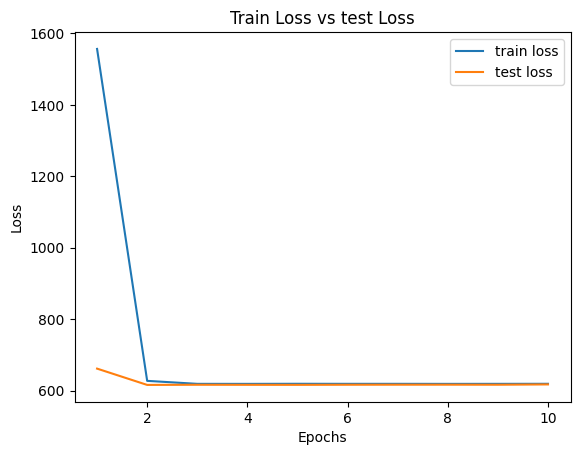

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1,num_epochs+1),train_loss,label='train loss')
plt.plot(range(1,num_epochs+1),test_losses,label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Train Loss vs test Loss")